# Plate Tectonic Stats

Basic kinematic information on:

1. MOR length
2. Spreading rates
3. Crustal production
4. Subduction convergence rates
5. Age of subducting crust
6. "World Uncertainty"

This workflow is __multithreaded__ and should execute very quickly!

In [1]:
from multiprocessing import Pool, cpu_count
from joblib import Parallel, delayed
import numpy as np
import os, glob
os.environ["DISABLE_GPLATELY_DEV_WARNING"] = "true"
import gplately.pygplates as pygplates
import ptt
import gplately
from gplately import tools
from slabdip import SlabDipper
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader
import netCDF4
import warnings
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
%matplotlib inline
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.0e3
earth_surface_area = 4.0*np.pi*earth_radius**2
tessellation_threshold_radians = np.radians(0.01)

# output grid resolution - should be identical to input grid resolution!
spacingX, spacingY = 0.2, 0.2
resX, resY = int(360./0.2 + 1), int(180./0.2 + 1)
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)
lonq, latq = np.meshgrid(lon_grid,lat_grid)

# reconstruction time steps and spacing
min_time = 0
max_time = 1799
timestep_size = 1

# reversed (start at max_time, end at min_time)
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)[::-1]

save_output_netcdf = False # !! important
save_output_snapshots = False

In [2]:
cell_area = tools.lat_area_function(lat_grid, lat_grid+spacingY, lon_grid.size)
cell_area = np.tile(cell_area.reshape(-1,1), lon_grid.size)

A function to define paths to grids for use in parallel.

In [3]:
# Don't change this: directory to input files
output_directory = "./Outputs/Notebook06/"
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)

In [4]:
grid_directory = "./Grids/InputGrids/"
def defineGridFiles():
    #grid_directory = input_directory+"SRGrids/"
    spreadrate_filename = grid_directory+"SpreadingRate/Cao2024_SPREADING_RATE_grid_{:.2f}Ma.nc"
    agegrid_filename = grid_directory+"SeafloorAge/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"
    return agegrid_filename, spreadrate_filename

In [5]:
# Location of Cao2024 1.8Ga plate model.
model_dir = "./utils/Cao_etal_2024_1.8_Ga_mantle_ref_frame"
# Rotation files (relative to input directory).
rotation_features = [
    model_dir+'/optimisation/1800_1000_rotfile_20240725.rot',
    model_dir+'/optimisation/1000_0_rotfile_20240725.rot',
]

# Topology features (absolute file paths).
# Only include those GPML files that are used for topologies.
topology_features = [
    model_dir+'/1800-1000_plate_boundaries.gpml',
    model_dir+'/250-0_plate_boundaries.gpml',
    model_dir+'/410-250_plate_boundaries.gpml',
    model_dir+'/1000-410-Convergence.gpml',
    model_dir+'/1000-410-Divergence.gpml',
    model_dir+'/1000-410-plate-boundaries.gpml',
    model_dir+'/1000-410-Transforms.gpml',
    model_dir+'/TopologyBuildingBlocks.gpml',
]
# Continent polygon features (absolute file paths).
continent_features = [
    model_dir+'/shapes_continents.gpmlz',
]

model = gplately.PlateReconstruction(rotation_model=rotation_features, topology_features=topology_features)

# For this notebook, we only need to define a set of passive margins as COBs.
COBs = grid_directory+"ContinentalMasks/passive_margin_features.gpmlz"
continents = grid_directory+"ContinentalMasks/continent_contour_features.gpmlz"

gplot = gplately.PlotTopologies(model, continents=continents, COBs=COBs)

Process plate boundary stats in parallel:

In [6]:
def plate_tectonic_stats(time, model, tessellation_threshold_radians):
    """All in SI units"""
    
    # Define paths to grids
    agegrid_filename, spreadrate_filename = defineGridFiles()

    ##################### Ridge spreading data ################################
    ridge_data = model.tessellate_mid_ocean_ridges(
        time,
        tessellation_threshold_radians,
        anchor_plate_id=0)
    headers = ['longitude', 'latitude', 'spreading_velocity_magnitude', 'arc_segment_length']
    ridge_df = pd.DataFrame(list(ridge_data), columns = headers)

    ridge_df.loc[ridge_df['spreading_velocity_magnitude'] >= 0]
    ridge_lon = ridge_df.longitude.to_numpy()
    ridge_lat = ridge_df.latitude.to_numpy()
    ridge_vel = ridge_df.spreading_velocity_magnitude.to_numpy()*1e-2 # m/yr
    ridge_len = np.radians(ridge_df.arc_segment_length.to_numpy()) * 1e3 * pygplates.Earth.mean_radius_in_kms # m

    ridge_len_sum = np.sum(ridge_len)
    ridge_vel_mean, ridge_vel_std = np.mean(ridge_vel), np.std(ridge_vel)
        
    # crustal surface area produced over 1 yr (old method)
    #ridge_surface_area = np.sum(ridge_vel * ridge_len)
    
    
    ###################### Subduction convergence data ########################
    # Initialise SlabDipper object, allocate it a spreading rate grid and an age grid
    dipper = SlabDipper()
    dipper._model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)

    subduction_df = dipper.tessellate_slab_dip(time, tessellation_threshold_radians)

    subduction_lon     = subduction_df.lon
    subduction_lat     = subduction_df.lat
    subduction_length  = subduction_df.length # m
    subd_len_sum = np.sum(subduction_length) 
        
    subduction_convergence = subduction_df.vel # m/yr
    subd_vel_mean, subd_vel_std = np.mean(subduction_convergence), np.std(subduction_convergence)
    
    # area subducted by trenches over 1 yr (old method)
    #subd_surface_area = np.sum(subduction_convergence * subduction_length) # m^2/yr

    ridge_surface_area, subd_surface_area = (
        model.crustal_production_destruction_rate(time)
    )
    
    # sample age grid
    age_interp = subduction_df.slab_age
    thickness = subduction_df.slab_thickness
    age_mean, age_std = np.mean(age_interp), np.std(age_interp)
    #age_global_mean = np.nanmean(gplately.Raster(agegrid_filename.format(time)).data)
    #age_global_std = np.nanstd(gplately.Raster(agegrid_filename.format(time)).data)

    # Accretion: Clift and Vannucchi (2004)
    accretion = (-0.4/0.068)*subduction_convergence + 0.4
    accretion_mean, accretion_std = np.mean(accretion), np.std(accretion)
    
    slab_dip = subduction_df.slab_dip
    slab_dip_mean, slab_dip_std = np.median(slab_dip), np.std(slab_dip)
    
    del subduction_df, ridge_df # clean up
    
    return(ridge_len_sum, ridge_vel_mean, ridge_vel_std, ridge_surface_area, \
           subd_len_sum,  subd_vel_mean,   subd_vel_std, subd_surface_area, \
           age_mean, age_std, accretion_mean, accretion_std, slab_dip_mean, slab_dip_std, \
          subduction_lon.to_numpy(), subduction_lat.to_numpy(), subduction_length.to_numpy())

In [7]:
plate_tectonic_stats(1000, model, tessellation_threshold_radians)

(42193216.0880379,
 0.06344076502574433,
 0.020922316719943254,
 2.387836063302284,
 68425916.17363378,
 0.02468655783031462,
 0.024404780315711194,
 2.4357322349515442,
 106.61408709071104,
 83.89199856798632,
 0.2547849539393258,
 0.14355753126888937,
 31.126397372333788,
 13.044288102273475,
 array([ 174.03424143,  174.03120983,  174.02817758, ..., -108.14843905,
        -108.14120084, -108.13396225]),
 array([ 32.0761853 ,  32.08584976,  32.09551416, ..., -11.69038869,
        -11.6974428 , -11.70449673]),
 array([ 555.97541862, 1111.95083724, 1111.95083724, ..., 1111.95083724,
        1111.95083724, 1426.0650709 ]))

In [8]:
import time

In [9]:
run_parallel = False

In [11]:


if run_parallel:
    ptt_stats = Parallel(n_jobs=-2,
                     verbose=1) \
    (delayed(plate_tectonic_stats) \
     (time, model, tessellation_threshold_radians) for time in reconstruction_times)
else:
    
    # Preallocate for scalar results
    stats = np.zeros((14, len(reconstruction_times)))
    
    # Lists to store variable-length arrays for each timestep
    subduction_lon_list = []
    subduction_lat_list = []
    subduction_length_list = []

    
    start = time.time()

    multiplier_time_notification = np.arange(100.,1801.,100.)
    for t, reconstruction_time in enumerate(reconstruction_times):
        output = plate_tectonic_stats(reconstruction_time, model, tessellation_threshold_radians)
    
        # First 14 scalar values go into the array
        stats[:, t] = output[:14]
    
        # Last 3 are arrays (converted to numpy arrays already by your function)
        subduction_lon_list.append(output[14])
        subduction_lat_list.append(output[15])
        subduction_length_list.append(output[16])

        
        if reconstruction_time in multiplier_time_notification:
            end = time.time()
            print("Stats for {}Ma complete, {}s elapsed.".format(reconstruction_time, end - start))



Stats for 1700Ma complete, 404.8844449520111s elapsed.
Stats for 1600Ma complete, 825.842221736908s elapsed.
Stats for 1500Ma complete, 1202.7417068481445s elapsed.
Stats for 1400Ma complete, 1610.168518781662s elapsed.
Stats for 1300Ma complete, 2000.1870086193085s elapsed.
Stats for 1200Ma complete, 2408.690810918808s elapsed.
Stats for 1100Ma complete, 2777.924929857254s elapsed.
Stats for 1000Ma complete, 3165.331624984741s elapsed.
Stats for 900Ma complete, 3597.330041885376s elapsed.
Stats for 800Ma complete, 4037.0074796676636s elapsed.
Stats for 700Ma complete, 4475.315369844437s elapsed.
Stats for 600Ma complete, 4896.996561765671s elapsed.
Stats for 500Ma complete, 5357.270270824432s elapsed.
Stats for 400Ma complete, 5819.309267997742s elapsed.
Stats for 300Ma complete, 6218.863479852676s elapsed.
Stats for 200Ma complete, 6638.762713909149s elapsed.
Stats for 100Ma complete, 7074.938097953796s elapsed.


In [12]:
if run_parallel:
    stats = np.zeros((14,reconstruction_times.size))
    subd_lons = np.zeros((1,reconstruction_times.size))
    subd_lats = np.zeros((1,reconstruction_times.size))
    
    for t, reconstruction_time in enumerate(reconstruction_times):
        stats[:,t] = np.array(ptt_stats[t][:-3]).T
else:
    subd_lons = subduction_lon_list
    subd_lats = subduction_lat_list

## Calculate total global passive margin lengths through time

In [13]:
def get_passive_margin_tot_len(time, gplot):
    total_passive_margin_length_kms = 0
    gplot.time = time
    for margin in gplot.COBs:   
        clat, clon = margin.get_reconstructed_geometry().get_centroid().to_lat_lon()
        earth_radius = tools.geocentric_radius(clat) / 1e3
        total_passive_margin_length_kms += margin.get_reconstructed_geometry().get_arc_length()*earth_radius
    return total_passive_margin_length_kms

In [14]:
if run_parallel:
    # Use ThreadingBackend - this is more compatible with purely pyGPlates routines
    passive_margin_lengths = Parallel(n_jobs=-2, backend='threading', verbose=1) \
    (delayed(get_passive_margin_tot_len) \
     (reconstruction_time, gplot
     ) for i, reconstruction_time in enumerate(reconstruction_times))
else:
    passive_margin_lengths = []
    for i, reconstruction_time in enumerate(reconstruction_times):
        passive_margin_lengths.append(get_passive_margin_tot_len(reconstruction_time, gplot))

## Rift lengths through time

In [10]:
rift_degassing_pd = pd.read_excel(
    "./utils/rift_degassing_2023dec01_rev2.xlsx",
      usecols=["Unnamed: 0", "Unnamed: 1"], header=0).drop([0, 1, 2, 3, 4],).rename(
    columns={'Unnamed: 0': 'time', 'Unnamed: 1': 'raw_rift_length'}
).reset_index(drop=True)

rift_times = rift_degassing_pd['time'].to_numpy()
raw_rift_length = rift_degassing_pd['raw_rift_length'].to_numpy()

In [11]:
rift_degassing_pd

,time,raw_rift_length
0,0,8160
1,1,8540
2,2,8540
3,3,22934
4,4,22804
...,...,...
996,996,2350.659959
997,997,2350.659959
998,998,2350.659959
999,999,2350.659959


### Rift multiplier (Merdith et al. (Science Advances, 2025))

The Neoproterozoic and Early Palaeozoic database predominantly identifies rifts that form during continental breakup and/or terrane detachment and migration. The database of the review paper's Ref. 33 contains these rifts, and also rifts formed in convergent settings, such as back-arc basins. This is likely a function of preservation bias. To counteract this issue, we calculated the fraction of rifts formed in convergent settings, which for the period 450–0 Ma is 0.44 (i.e. on average 44% of total rift length in the database (33) formed in convergent settings and is unaccounted for in the estimate of ref(34)). Assuming that this proportion is constant back to 600 Ma, we applied a rift length multiplier of:

$1/0.56 \approx 1.79$

to all rift lengths earlier than 450Ma. 

In [16]:
import scipy.ndimage as sn
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [12]:
multiplier_rift_length = []
for t, length in enumerate(raw_rift_length):
    if rift_times[t] > 450:
        new_length = length / 0.56
    else:
        new_length = length
    multiplier_rift_length.append(new_length)

#Get the average median-filtered raw rift length from 0-900Ma. 
# Apply a 20Myr window median filter to the multiplier rift lengths:
from scipy.signal import savgol_filter
import scipy.ndimage as sn
rift_time_window = 20
average_rift_length = np.mean(
    sn.median_filter(raw_rift_length[0:900].astype(float), size=rift_time_window)) # m to km
average_corrected_rift_length = np.mean(
    sn.median_filter(np.array(multiplier_rift_length[0:900]).astype(float), size=rift_time_window)) # m to km


extended_multiplier_rift_length = []
extended_raw_rift_length = []
for t, time in enumerate(reconstruction_times[::-1]):
    if time > 900:
        extended_multiplier_rift_length.append(average_corrected_rift_length)
        extended_raw_rift_length.append(average_rift_length)
    else:
        extended_multiplier_rift_length.append(multiplier_rift_length[t])
        extended_raw_rift_length.append(raw_rift_length[t])

extended_multiplier_rift_length = np.array(extended_multiplier_rift_length)
extended_raw_rift_length = np.array(extended_raw_rift_length)
    
# Apply a 20Myr window median filter to the multiplier rift lengths:
#from scipy.signal import savgol_filter
filtered_multiplier_rift_lengths = sn.median_filter(extended_multiplier_rift_length, size=20)
filtered_raw_rift_lengths = sn.median_filter(extended_raw_rift_length.astype(float), size=20)

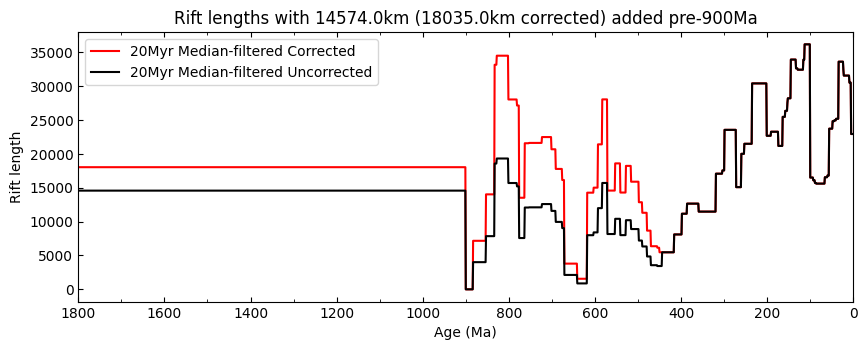

In [17]:
# Visualise rift length
fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rift length', xlim=[max_time+1,0])

ax.set_title("Rift lengths with {}km ({}km corrected) added pre-900Ma".format(np.ceil(average_rift_length), np.ceil(average_corrected_rift_length)))


ax.plot(reconstruction_times[::-1], filtered_multiplier_rift_lengths, c="r", label='20Myr Median-filtered Corrected')
ax.plot(reconstruction_times[::-1], filtered_raw_rift_lengths, c="k", label='20Myr Median-filtered Uncorrected')

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
ax.legend()

## Create some plots

### Continental arc lengths and carbonate platform-intersecting trench lengths are imported from Notebook 4.

In [18]:
# Note that both CSVs are saved such that the first row is 0Ma. When saving to the notebook 6 csv, flip the time arrays.

cont_arc_len_pd = pd.read_csv('./Outputs/Notebook04/csv/continental_arc_length.csv', index_col=0, header=[0])
cont_arc_len_pd = cont_arc_len_pd.reindex(index=reconstruction_times)
carb_plat_len_pd = pd.read_csv('./Outputs/Notebook04/csv/carbonate_platform_length.csv', index_col=0, header=[0])
carb_plat_len_pd = carb_plat_len_pd.reindex(index=reconstruction_times)

min_cont_arc_length = cont_arc_len_pd['min_continental_arc_length'].to_numpy()
mean_cont_arc_length = cont_arc_len_pd['mean_continental_arc_length'].to_numpy()
max_cont_arc_length = cont_arc_len_pd['max_continental_arc_length'].to_numpy()
min_carb_plat_int_length = carb_plat_len_pd['min_carbonate_platform_length'].to_numpy()
mean_carb_plat_int_length = carb_plat_len_pd['mean_carbonate_platform_length'].to_numpy()
max_carb_plat_int_length = carb_plat_len_pd['max_carbonate_platform_length'].to_numpy()

In [19]:
carb_plat_len_pd

,min_carbonate_platform_length,mean_carbonate_platform_length,max_carbonate_platform_length
1799,0.000000,0.000000,0.000000
1798,0.000000,0.000000,0.000000
1797,0.000000,0.000000,0.000000
1796,0.000000,0.000000,0.000000
1795,0.000000,0.000000,0.000000
...,...,...,...
4,15557.563566,18953.002126,21500.104031
3,15543.730237,18242.631305,20967.596278
2,15543.730237,18242.631305,20967.596278
1,15510.808727,17941.479964,20552.260783


In [20]:
cont_arc_len_pd

,min_continental_arc_length,mean_continental_arc_length,max_continental_arc_length
1799,27319.895042,30600.232699,32632.031712
1798,27281.069959,30600.232699,32628.142647
1797,27204.532851,30501.002037,32521.906689
1796,27204.532851,30501.002037,32521.906689
1795,27204.532851,30501.002037,32521.906689
...,...,...,...
4,43745.720107,45192.516353,45349.122976
3,43329.912982,44214.647074,44214.647074
2,43329.912982,44214.647074,44214.647074
1,43306.820709,43996.009647,43996.009647


### Scale continental arc lengths pre-460Ma and use carbonate platform lengths from 410-0Ma.

In [21]:
# We consider three different percentages of carbonate platform degassing rates. 
percentages = [0.15, 0.25, 0.35]
d_tols = [250., 350., 450.]

time_window = 10 # Myr

scaled_arc_length = np.zeros((len(reconstruction_times), len(d_tols)))
carbplat_reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

for j, percentage in enumerate(percentages):
    
    for i, t in enumerate(reconstruction_times):
        # Scale all degassing for times earlier than 460Ma.
        if t > 460:
            scaled_arc_length[i,0] = percentage * min_cont_arc_length[i]
            scaled_arc_length[i,1] = percentage * mean_cont_arc_length[i]
            scaled_arc_length[i,2] = percentage * max_cont_arc_length[i]
        
        else:
            
            scaled_arc_length[i,0] = min_carb_plat_int_length[i]
            scaled_arc_length[i,1] = mean_carb_plat_int_length[i]
            scaled_arc_length[i,2] = max_carb_plat_int_length[i]
    
    data_out = np.column_stack((

        scaled_arc_length[:,0],
        scaled_arc_length[:,1],
        scaled_arc_length[:,2],
    ))

    # These values are in Mt/yr
    headers = ['min_combined_continent_carbonate_platform_length', 
               'mean_combined_continent_carbonate_platform_length',
               'max_combined_continent_carbonate_platform_length' ]

    # Save PDF to time 0-1000.
    carbon_subducted_df = pd.DataFrame(list(data_out), columns = headers, index=reconstruction_times) 
    carbon_subducted_df.to_csv(
        output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100)
    )
carbon_subducted_df
    

,min_combined_continent_carbonate_platform_length,mean_combined_continent_carbonate_platform_length,max_combined_continent_carbonate_platform_length
1799,9561.963265,10710.081445,11421.211099
1798,9548.374486,10710.081445,11419.849927
1797,9521.586498,10675.350713,11382.667341
1796,9521.586498,10675.350713,11382.667341
1795,9521.586498,10675.350713,11382.667341
...,...,...,...
4,15557.563566,18953.002126,21500.104031
3,15543.730237,18242.631305,20967.596278
2,15543.730237,18242.631305,20967.596278
1,15510.808727,17941.479964,20552.260783


### The 0.25 percentage dataframe is what is saved to the Notebook 6 csv

In [22]:
percentage = 0.25

# This is saved from time 0-1000Ma.
len_pd = pd.read_csv(
    output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100),
    index_col=0
)

headers = ['min_combined_continent_carbonate_platform_length', 
           'mean_combined_continent_carbonate_platform_length',
           'max_combined_continent_carbonate_platform_length' ]

min_scaled_len = np.ravel(len_pd[headers[0]].to_numpy())
mean_scaled_len = np.ravel(len_pd[headers[1]].to_numpy())
max_scaled_len = np.ravel(len_pd[headers[2]].to_numpy())

### Gather average global ocean floor age over time

In [24]:
def calculate_average_global_seafloor_age(time):
    # Define paths to grids
    agegrid_filename, _ = defineGridFiles()
    age_global_mean = np.nanmean(gplately.Raster(agegrid_filename.format(time)).data)
    age_global_std = np.nanstd(gplately.Raster(agegrid_filename.format(time)).data)
    return age_global_mean, age_global_std

In [25]:
# Use ThreadingBackend - this is more compatible with purely pyGPlates routines
global_age_data = Parallel(n_jobs=-2, verbose=1) \
(delayed(calculate_average_global_seafloor_age) \
 (reconstruction_time, 
 ) for reconstruction_time in reconstruction_times)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 9 concurrent workers.
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-2)]: Done 1232 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 1782 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-2)]: Done 1800 out of 1800 | elapsed:  2.2min finished


In [26]:
global_age_data_arr = np.array(global_age_data, dtype=object)

age_global_mean_unfiltered = global_age_data_arr[:,0]
age_global_std_unfiltered = global_age_data_arr[:,1]

In [27]:
time_window = 10 #Myr
age_global_mean    = sn.median_filter(age_global_mean_unfiltered.astype(float), size=time_window) 
age_global_std     = sn.median_filter(age_global_std_unfiltered.astype(float), size=time_window)

In [28]:

# unpack stats
ridge_len_sum      = sn.median_filter(stats[0] * 1e-3, size=time_window) # m to km
ridge_vel_mean     = sn.median_filter(stats[1] * 100, size=time_window)  # m/yr to cm/yr
ridge_vel_std      = sn.median_filter(stats[2] * 100, size=time_window)  # m/yr to cm/yr
ridge_surface_area = sn.median_filter(stats[3], size=time_window) # already in km^2/a
subd_len_sum       = sn.median_filter(stats[4] * 1e-3, size=time_window) # m to km
subd_vel_mean      = sn.median_filter(stats[5] * 100, size=time_window)  # m/yr to cm/yr
subd_vel_std       = sn.median_filter(stats[6] * 100, size=time_window)  # m/yr to cm/yr
subd_surface_area  = sn.median_filter(stats[7], size=time_window) # already in km^2/a
age_mean           = sn.median_filter(stats[8], size=time_window)
age_std            = sn.median_filter(stats[9], size=time_window)
accretion_mean     = sn.median_filter(stats[10], size=time_window)
accretion_std      = sn.median_filter(stats[11], size=time_window)
slab_dip_mean      = sn.median_filter(stats[12], size=time_window)
slab_dip_std       = sn.median_filter(stats[13], size=time_window)
passive_margin_lengths_global = sn.median_filter(passive_margin_lengths, size=time_window)


In [29]:
# save xy data
data_out = np.column_stack((
            ridge_len_sum,
            ridge_vel_mean,
            ridge_vel_std,
            ridge_surface_area,
            subd_len_sum,
            subd_vel_mean,
            subd_vel_std,
            subd_surface_area,
            age_mean,
            age_std,
            accretion_mean*100,
            accretion_std*100,
            slab_dip_mean,
            slab_dip_std,
            passive_margin_lengths_global,
            min_cont_arc_length,
            mean_cont_arc_length,
            max_cont_arc_length,
            min_carb_plat_int_length,
            mean_carb_plat_int_length,
            max_carb_plat_int_length,
            min_scaled_len,
            mean_scaled_len,
            max_scaled_len,
            age_global_mean,
            age_global_std
            ))

headers = ['ridge_length', 
           'ridge_vel_mean', 
           'ridge_vel_std', 
           'ridge_surface_area', 
           'subduction_length', 
           'subduction_vel_mean', 
           'subduction_vel_std', 
           'subduction_surface_area', 
           'age_mean', 
           'age_std', 
           'accretion_mean', 
           'accretion_std', 
           'slab_dip_mean', 
           'slab_dip_std',
           'passive_margin_length',
           'min_continental_arc_length',
           'mean_continental_arc_length',
           'max_continental_arc_length',
           'min_carb_plat_continental_arc_length',
           'mean_carb_plat_continental_arc_length',
           'max_carb_plat_continental_arc_length',
           'min_combined_arc_length',
           'mean_combined_arc_length',
           'max_combined_arc_length',
           'global_age_mean',
           'global_age_std'
]

plate_tectonic_stats = pd.DataFrame(list(data_out), columns=headers, index=reconstruction_times)
plate_tectonic_stats.to_csv(output_directory+'/csv/06_plate_tectonic_stats.csv',  index_label='age')

Reread the csv and plot using the dataframe

In [23]:
ptt_pd = pd.read_csv(output_directory+'/csv/06_plate_tectonic_stats.csv', index_col=0)
ptt_pd = ptt_pd.reindex(index=reconstruction_times)

ridge_len_sum = ptt_pd['ridge_length'].to_numpy()
ridge_vel_mean = ptt_pd['ridge_vel_mean'].to_numpy()
ridge_vel_std = ptt_pd['ridge_vel_std'].to_numpy()

ridge_surface_area = ptt_pd['ridge_surface_area'].to_numpy()
subd_len_sum = ptt_pd['subduction_length'].to_numpy()
subd_vel_mean = ptt_pd['subduction_vel_mean'].to_numpy()
subd_vel_std = ptt_pd['subduction_vel_std'].to_numpy()

subd_surface_area = ptt_pd['subduction_surface_area'].to_numpy()
age_mean = ptt_pd['age_mean'].to_numpy()
age_std = ptt_pd['age_std'].to_numpy()
accretion_mean = ptt_pd['accretion_mean'].to_numpy()
accretion_std = ptt_pd['accretion_std'].to_numpy()
slab_dip_mean = ptt_pd['slab_dip_mean'].to_numpy()
slab_dip_std = ptt_pd['slab_dip_std'].to_numpy()

passive_margin_lengths_global = ptt_pd['passive_margin_length'].to_numpy()
min_cont_arc_length = ptt_pd['min_continental_arc_length'].to_numpy()
mean_cont_arc_length = ptt_pd['mean_continental_arc_length'].to_numpy()
max_cont_arc_length = ptt_pd['max_continental_arc_length'].to_numpy()

min_carb_plat_int_length = ptt_pd['min_carb_plat_continental_arc_length'].to_numpy()
mean_carb_plat_int_length = ptt_pd['mean_carb_plat_continental_arc_length'].to_numpy()
max_carb_plat_int_length = ptt_pd['max_carb_plat_continental_arc_length'].to_numpy()

age_global_mean = ptt_pd['global_age_mean'].to_numpy()
age_global_std = ptt_pd['global_age_std'].to_numpy()

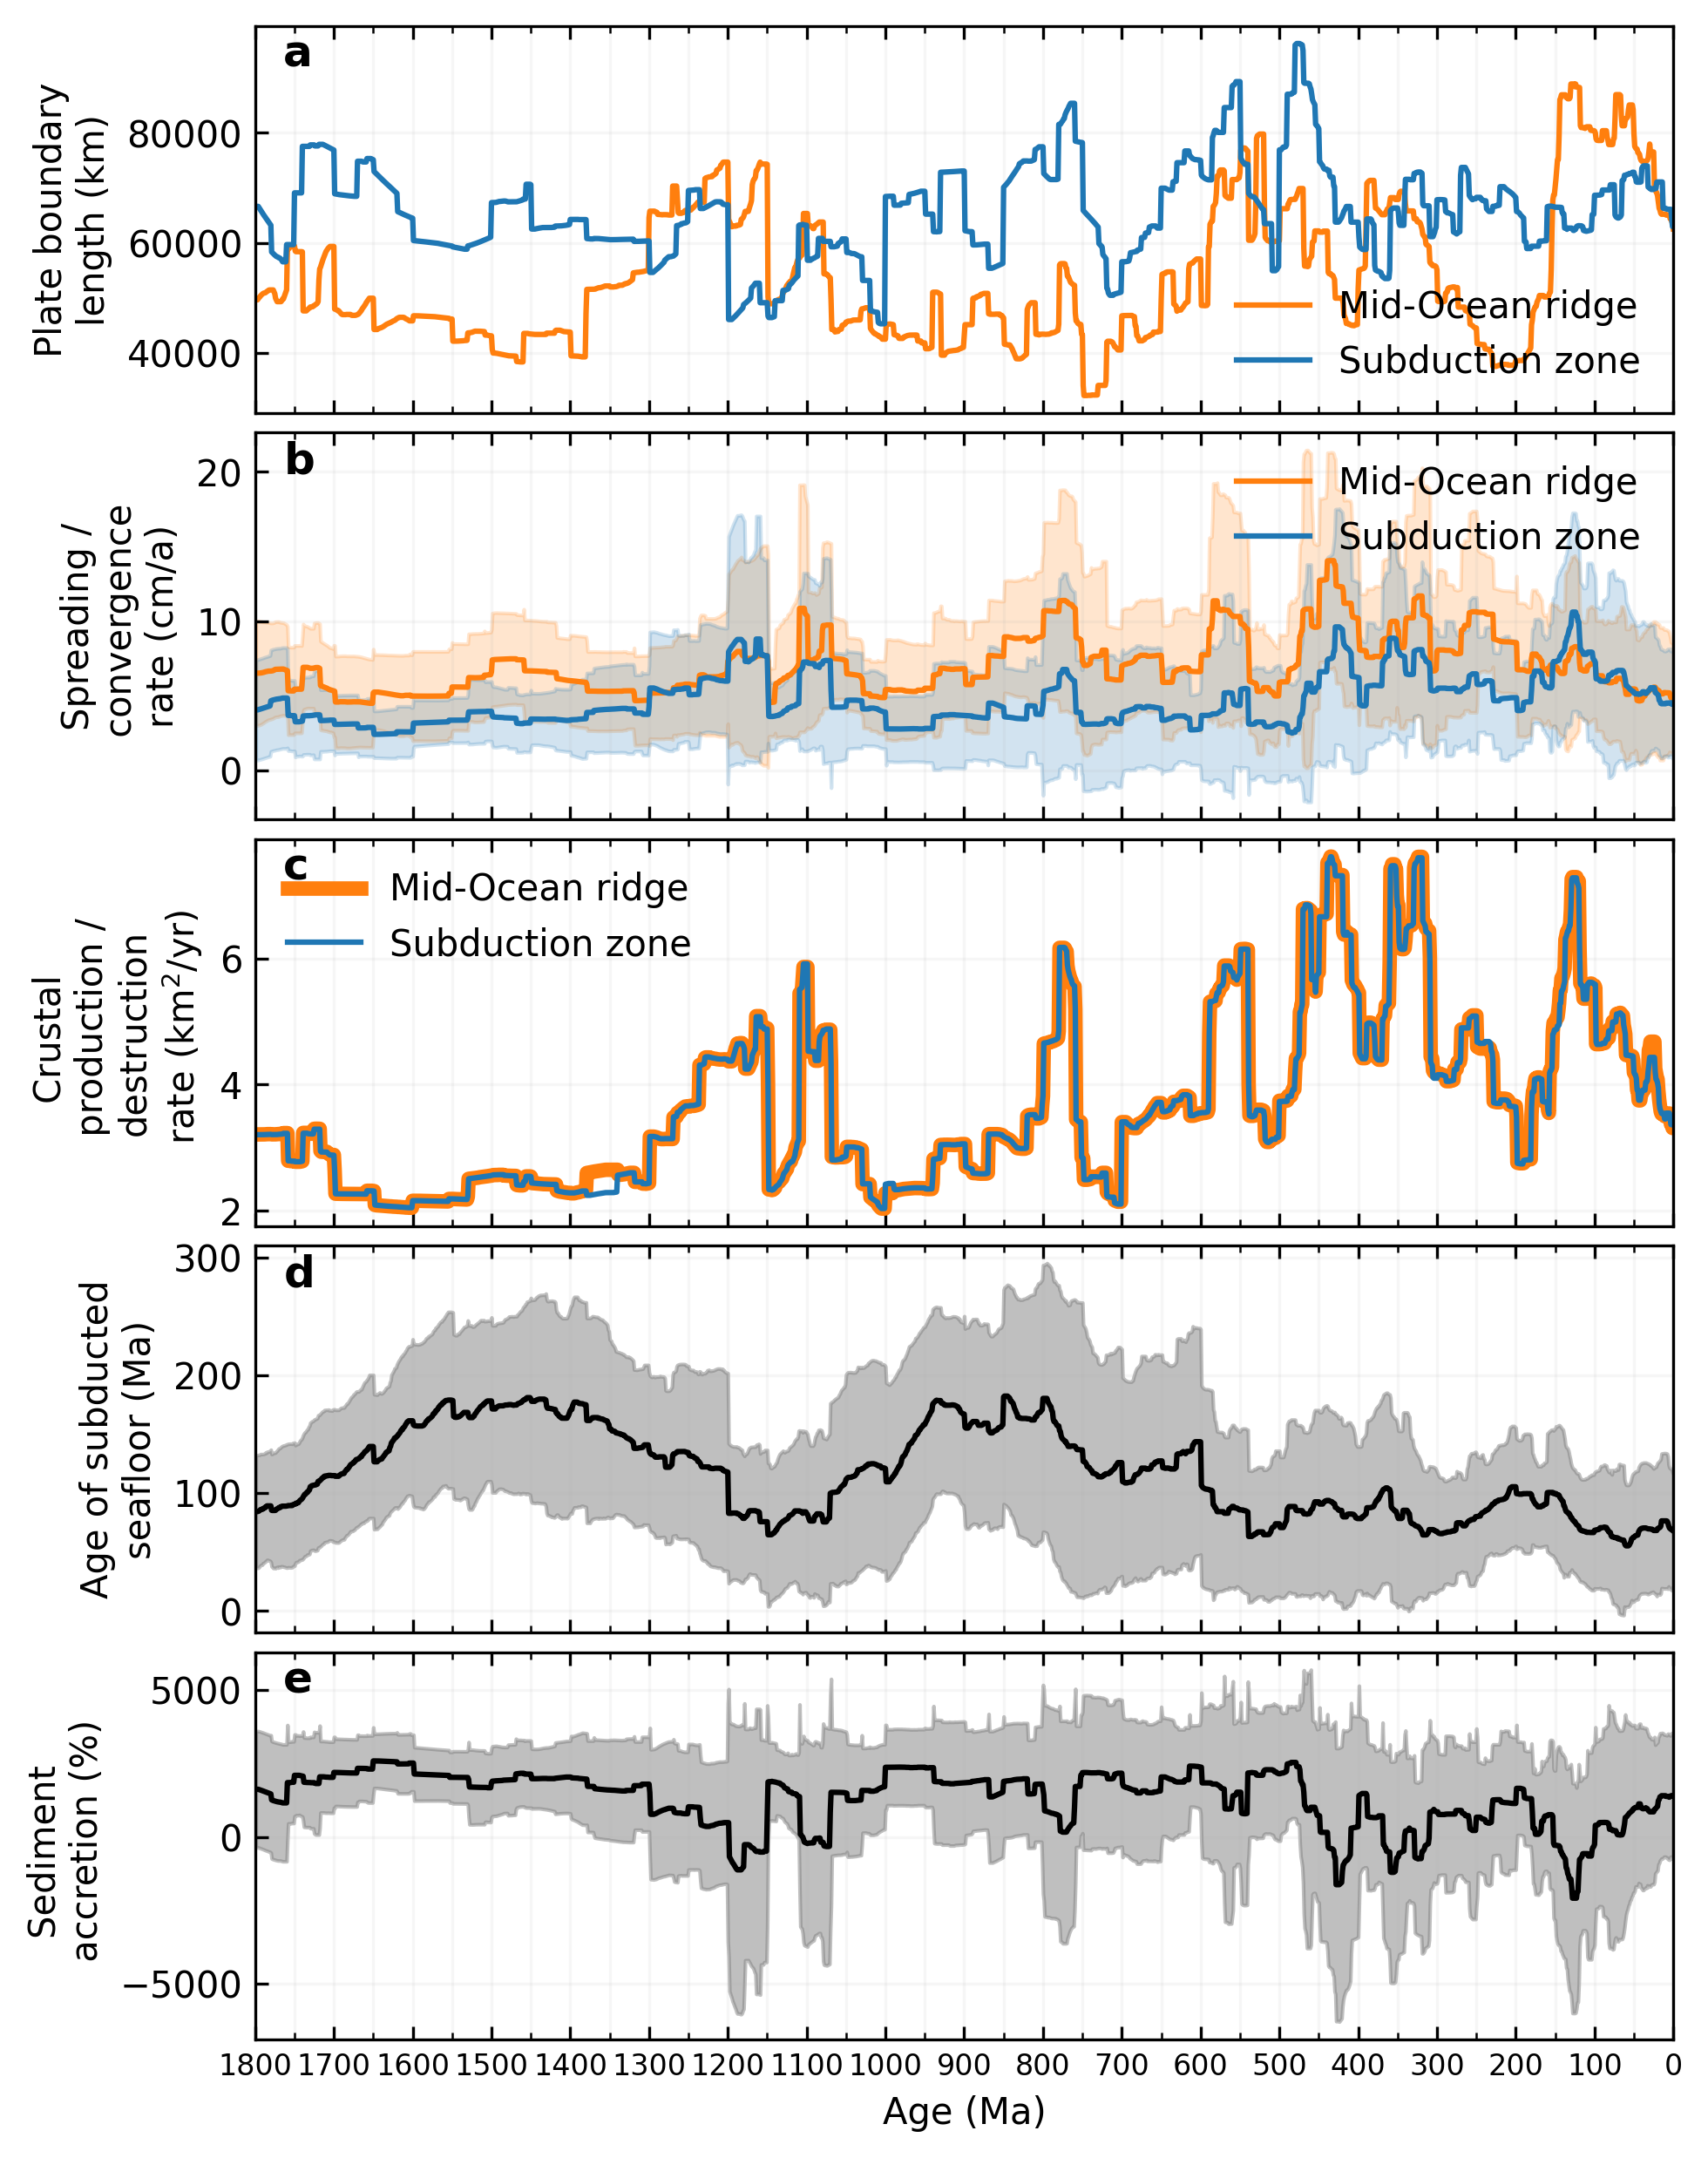

In [24]:
fig, axes = plt.subplots(5, 1, figsize=(7,10), dpi=300)
fig.subplots_adjust(hspace=0.05)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
n_axes = len(axes)

axes[0].set_ylabel('Plate boundary\nlength (km)')
ln1, = axes[0].plot(reconstruction_times, ridge_len_sum, c='C1',  label="Mid-Ocean ridge")
ln2, = axes[0].plot(reconstruction_times, subd_len_sum, c='C0', label='Subduction zone')
axes[0].legend(loc='lower right', frameon=False)

axes[1].set_ylabel('Spreading /\n convergence\nrate (cm/a)')
axes[1].fill_between(reconstruction_times, ridge_vel_mean-ridge_vel_std, ridge_vel_mean+ridge_vel_std,
                     edgecolor='k', color='C1', alpha=0.2)
axes[1].fill_between(reconstruction_times, subd_vel_mean-subd_vel_std, subd_vel_mean+subd_vel_std,
                     edgecolor='k', color='C0', alpha=0.2)
axes[1].plot(reconstruction_times, ridge_vel_mean, c='C1', label="Mid-Ocean ridge")
axes[1].plot(reconstruction_times, subd_vel_mean, c='C0', label="Subduction zone")
axes[1].legend(loc='upper right', frameon=False)

axes[2].set_ylabel('Crustal \n production /\ndestruction\n rate (km$^2$/yr)')
axes[2].plot(reconstruction_times, ridge_surface_area, linewidth=4, c='C1', label="Mid-Ocean ridge")
axes[2].plot(reconstruction_times, subd_surface_area, c='C0', label='Subduction zone')
axes[2].legend(loc='upper left', frameon=False)

axes[3].set_ylabel('Age of subducted\nseafloor (Ma)')
axes[3].fill_between(reconstruction_times, age_mean-age_std, age_mean+age_std, color='0.5', alpha=0.5)
axes[3].plot(reconstruction_times, age_mean, c='k')

axes[4].set_ylabel('Sediment \n accretion (%)')
axes[4].fill_between(reconstruction_times, (accretion_mean-accretion_std)*100, (accretion_mean+accretion_std)*100,
                    color='0.5', alpha=0.5)
axes[4].plot(reconstruction_times, accretion_mean*100, c='k')
plt.grid(which='both', alpha=0.1)
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, 0)
    ax.set_xticks(np.arange(1800,-1,-100))
    plt.xticks(fontsize=8)
    if i < n_axes-1:
        ax.grid(alpha=0.1, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticklabels([])
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
    else:
        #ax.set_xticklabels(axes[6].get_xticks()[::2], rotation = 45)
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
        ax.set_xticklabels(axes[n_axes-1].get_xticks())
        ax.set_xlabel("Age (Ma)")
        
img_id = ["a","b","c","d","e",]
for i, ax in enumerate(axes):
    
    ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')


plt.show()
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.svg", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt1.png", dpi=300, bbox_inches='tight')


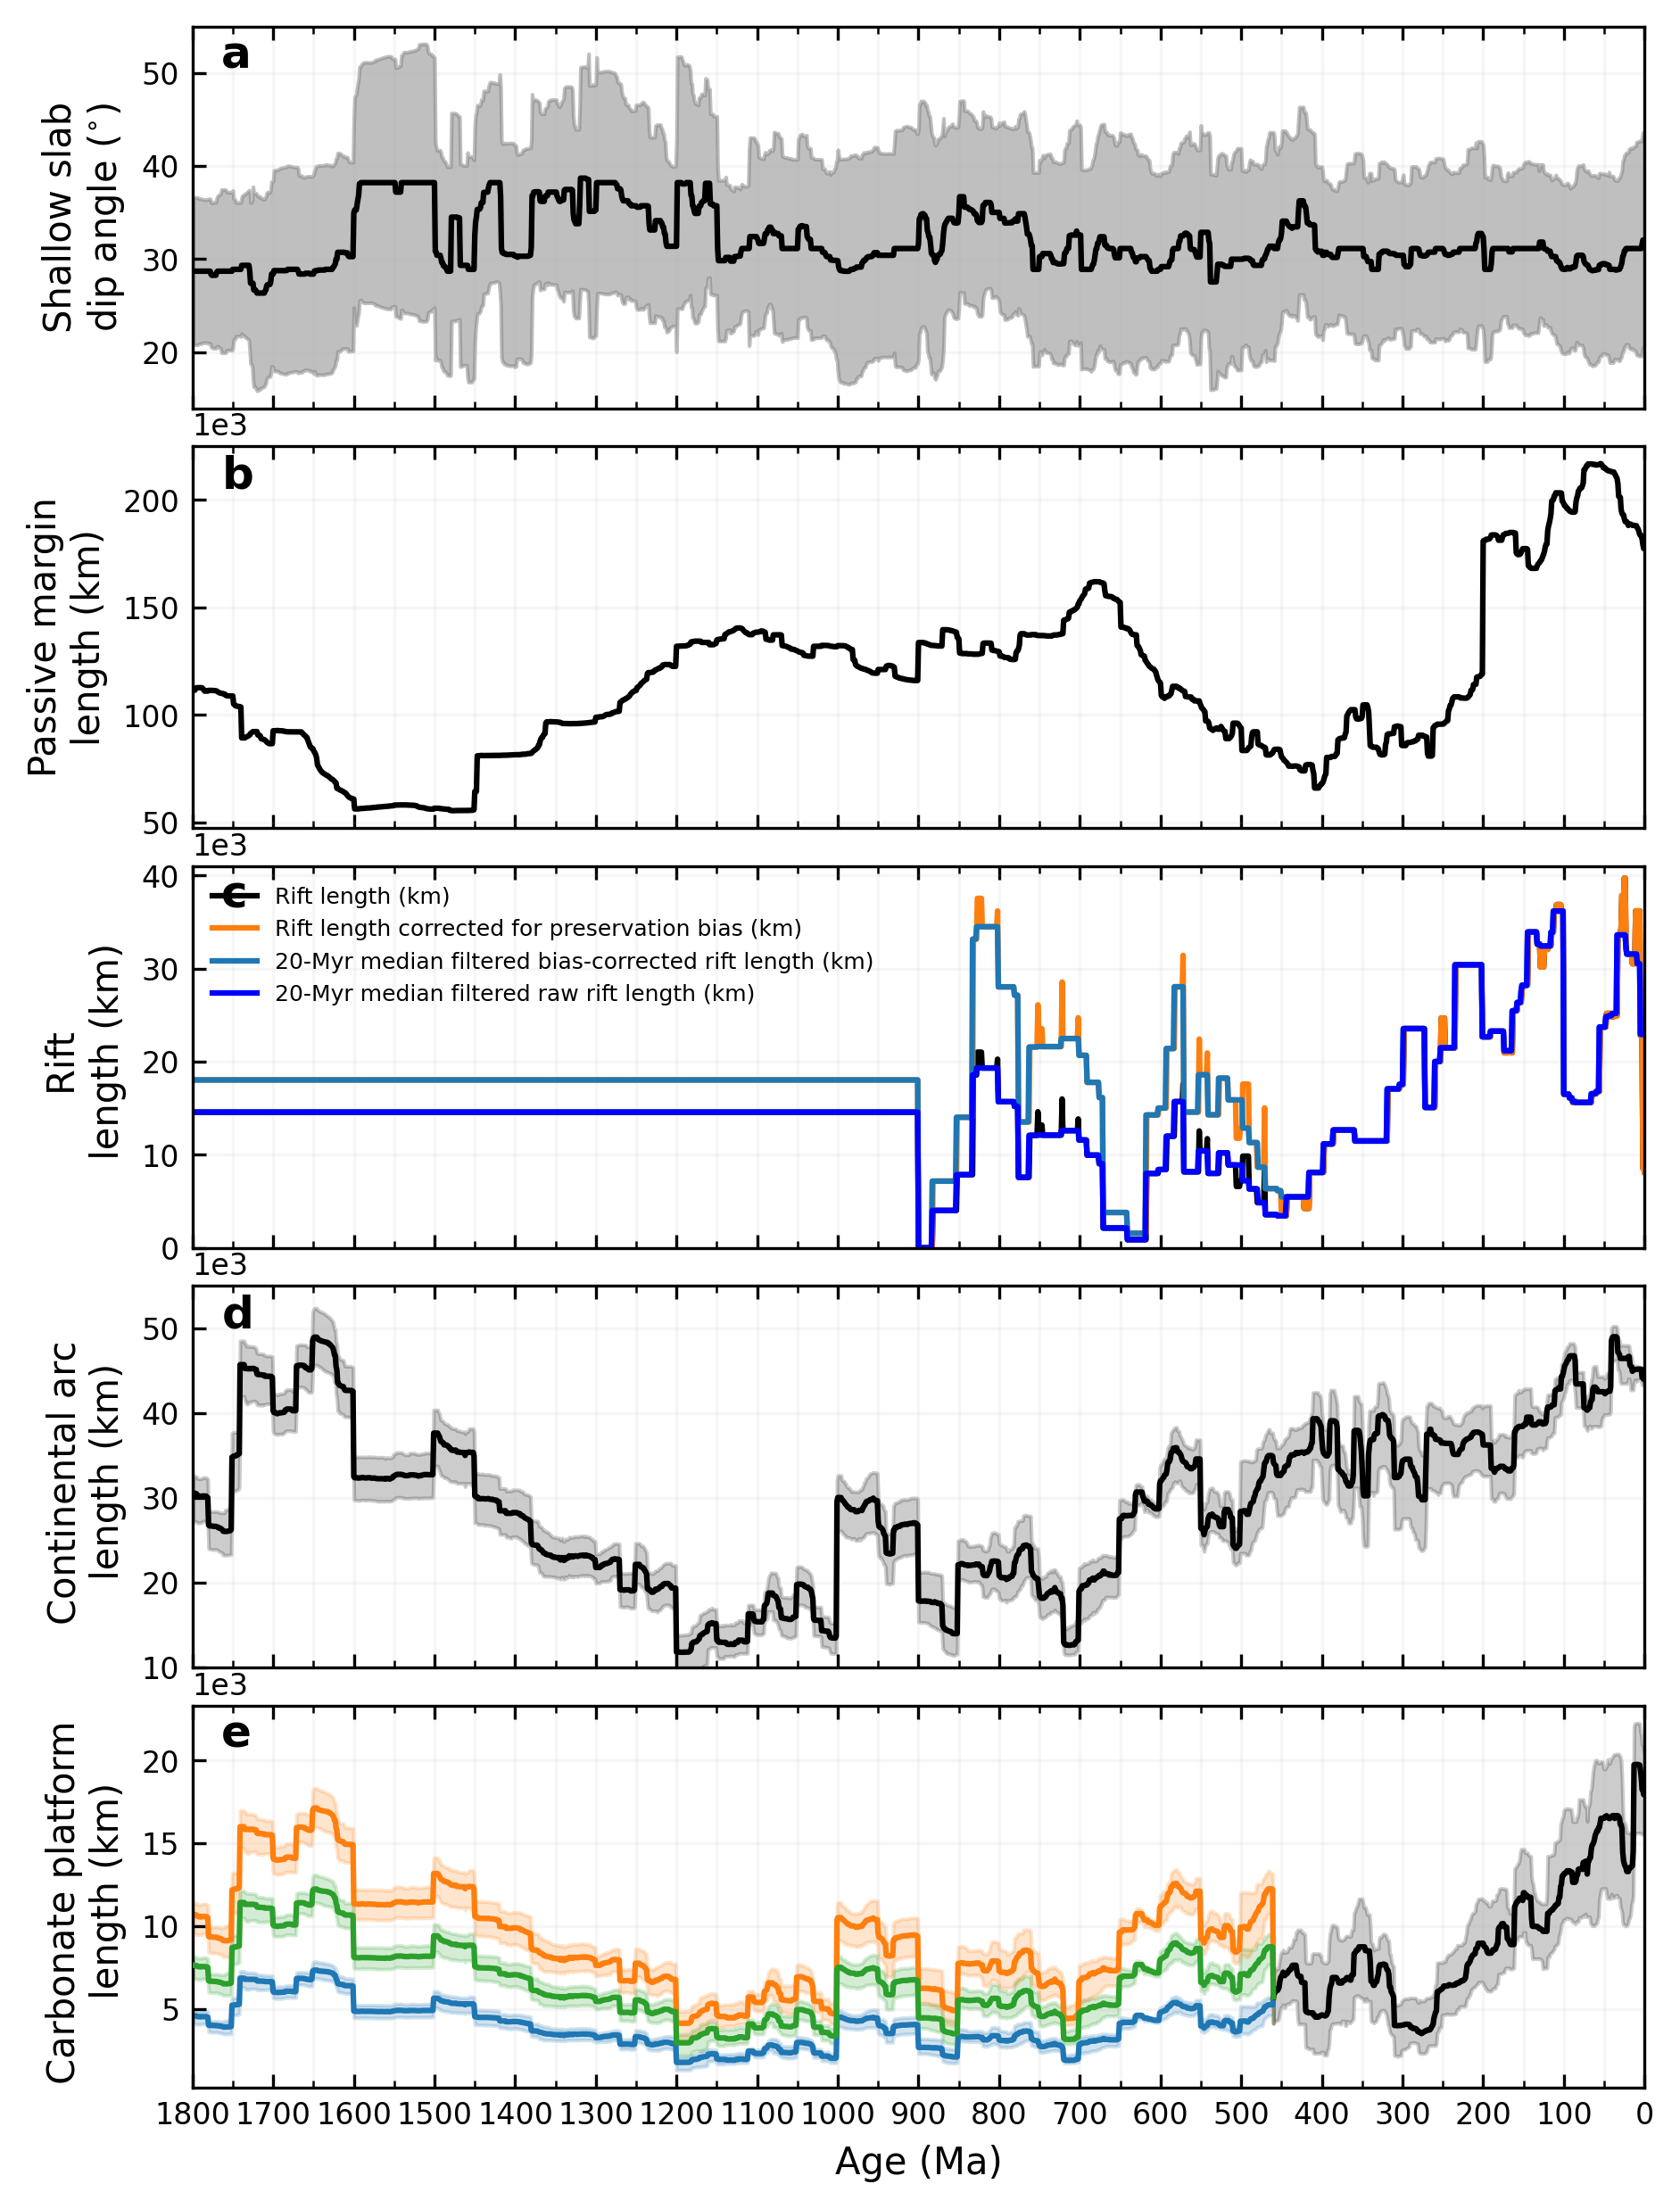

In [39]:
fig, axes = plt.subplots(5, 1, figsize=(7,10), dpi=300)

fig.subplots_adjust(hspace=0.05)
n_axes = len(axes)

for n, ax in enumerate(axes):
    axes[n].tick_params(axis='both', labelsize=8)
    if n>0:
        axes[n].ticklabel_format(style='sci', axis='y', scilimits=(3,3))
        axes[n].yaxis.get_offset_text().set_fontsize(8)
        
axes[0].set_ylabel('Shallow slab\ndip angle ($^{\circ}$)')
axes[0].fill_between(reconstruction_times, slab_dip_mean-slab_dip_std, slab_dip_mean+slab_dip_std,
                     color='0.5', alpha=0.5)
axes[0].plot(reconstruction_times, slab_dip_mean, c='k')

axes[1].set_ylabel('Passive margin\nlength (km)')
axes[1].plot(reconstruction_times, passive_margin_lengths_global, c='k')
axes[1].set_xticks(np.arange(1800,-1,-100),  )
axes[1].set_yticks(np.arange(50000,210001,50000))
#axes[1].set_xticklabels(axes[1].get_xticks(), rotation = 45)
axes[1].ticklabel_format(useOffset=True)


axes[2].set_ylabel('Rift \n length (km)')
ln3 = axes[2].plot(reconstruction_times[::-1], 
                   extended_raw_rift_length, c='k', label="Rift length (km)"
)
ln3 = axes[2].plot(reconstruction_times[::-1], 
                   extended_multiplier_rift_length, c='C1', label="Rift length corrected for preservation bias (km)"
)
ln3 = axes[2].plot(reconstruction_times[::-1], 
                   filtered_multiplier_rift_lengths, c='C0', label="20-Myr median filtered bias-corrected rift length (km)"
)
ln3 = axes[2].plot(reconstruction_times[::-1], 
                   filtered_raw_rift_lengths, c='b', label="20-Myr median filtered raw rift length (km)")

axes[2].set_xticks(np.arange(1800,-1,-100),  )
axes[2].set_ylim([0,41000])
axes[2].set_yticks(np.arange(0,41001,10000))
axes[2].legend(loc='upper left', frameon=False, prop={'size': 6})


axes[3].set_ylabel('Continental arc \n length (km)')
ln3 = axes[3].plot(reconstruction_times, 
                   mean_cont_arc_length, c='k', label="Mean dist. tolerance {} km".format(350)
)
axes[3].fill_between(reconstruction_times, min_cont_arc_length, max_cont_arc_length, 
                 color='k', alpha=0.2, label="Uncertainty from min and max dist. tolerances")
axes[3].set_xticks(np.arange(1800,-1,-100),  )
axes[3].set_ylim([10000,55000])
axes[3].set_yticks(np.arange(10000,55001,10000))


colors = ['C0', 'C2', 'C1']
# This is plotted directly from the csv saved above. We use the arc_times array which is set from 0,1000. 
arc_times = reconstruction_times[::-1]
for c in range(0,3):
    
    percentage = percentages[c]
    
    len_pd = pd.read_csv(
        output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100),
        index_col=0
    )
    
    headers = ['min_combined_continent_carbonate_platform_length', 
               'mean_combined_continent_carbonate_platform_length',
               'max_combined_continent_carbonate_platform_length' ]

    # Flip the arrays to match easy slicing of the array
    min_scaled_len = np.ravel(len_pd[headers[0]].to_numpy())[::-1]
    mean_scaled_len = np.ravel(len_pd[headers[1]].to_numpy())[::-1]
    max_scaled_len = np.ravel(len_pd[headers[2]].to_numpy())[::-1]

    # If plotting the 35% reduction, we want it to be the topmost layer - hence give it zorder 4. 
    if c == 1:
        axes[4].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100),
            zorder=4
        )
    else:

        axes[4].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100)
        )
    axes[4].fill_between(
        arc_times[460:], 
        min_scaled_len[460:], 
        max_scaled_len[460:], 
        color=colors[c], alpha=0.2, 
        #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
    )
    
# Plot all fluxes from 0-499 in black
axes[4].plot(
    arc_times[:461], 
    mean_scaled_len[:461],
    c='k', 
    label='Carbonate platform length post-460Ma')

axes[4].fill_between(
    arc_times[:461], 
    min_scaled_len[:461], 
    max_scaled_len[:461], 
    color='k', alpha=0.2, 
    #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
)
axes[4].set_ylabel('Carbonate platform \n length (km)')
axes[4].set_xticks(np.arange(1800,-1,-100),  )

plt.grid(which='both', alpha=0.1)

for i, ax in enumerate(axes):
    ax.set_xlim(max_time, 0)
    ax.set_xticks(np.arange(1800,-1,-100))
    if i < n_axes-1:
        ax.grid(alpha=0.1, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticklabels([])
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
    else:
        #ax.set_xticklabels(axes[6].get_xticks()[::2], rotation = 45)
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
        ax.set_xticklabels(axes[n_axes-1].get_xticks())
        ax.set_xlabel("Age (Ma)")
        
img_id = ["a","b","c","d","e",]
for i, ax in enumerate(axes):
    
    ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')
    
plt.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.svg", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt2.png", dpi=300, bbox_inches='tight')



Plate boundary length (km)
Spreading/convergence rate (cm/a)
Crustal production rate  (km^2/yr) (no destruction rate curve, seeing that the two are the same now anyway)
Passive margin length (km)
Rift length (km)
Continental arcs with carb. platforms (km)

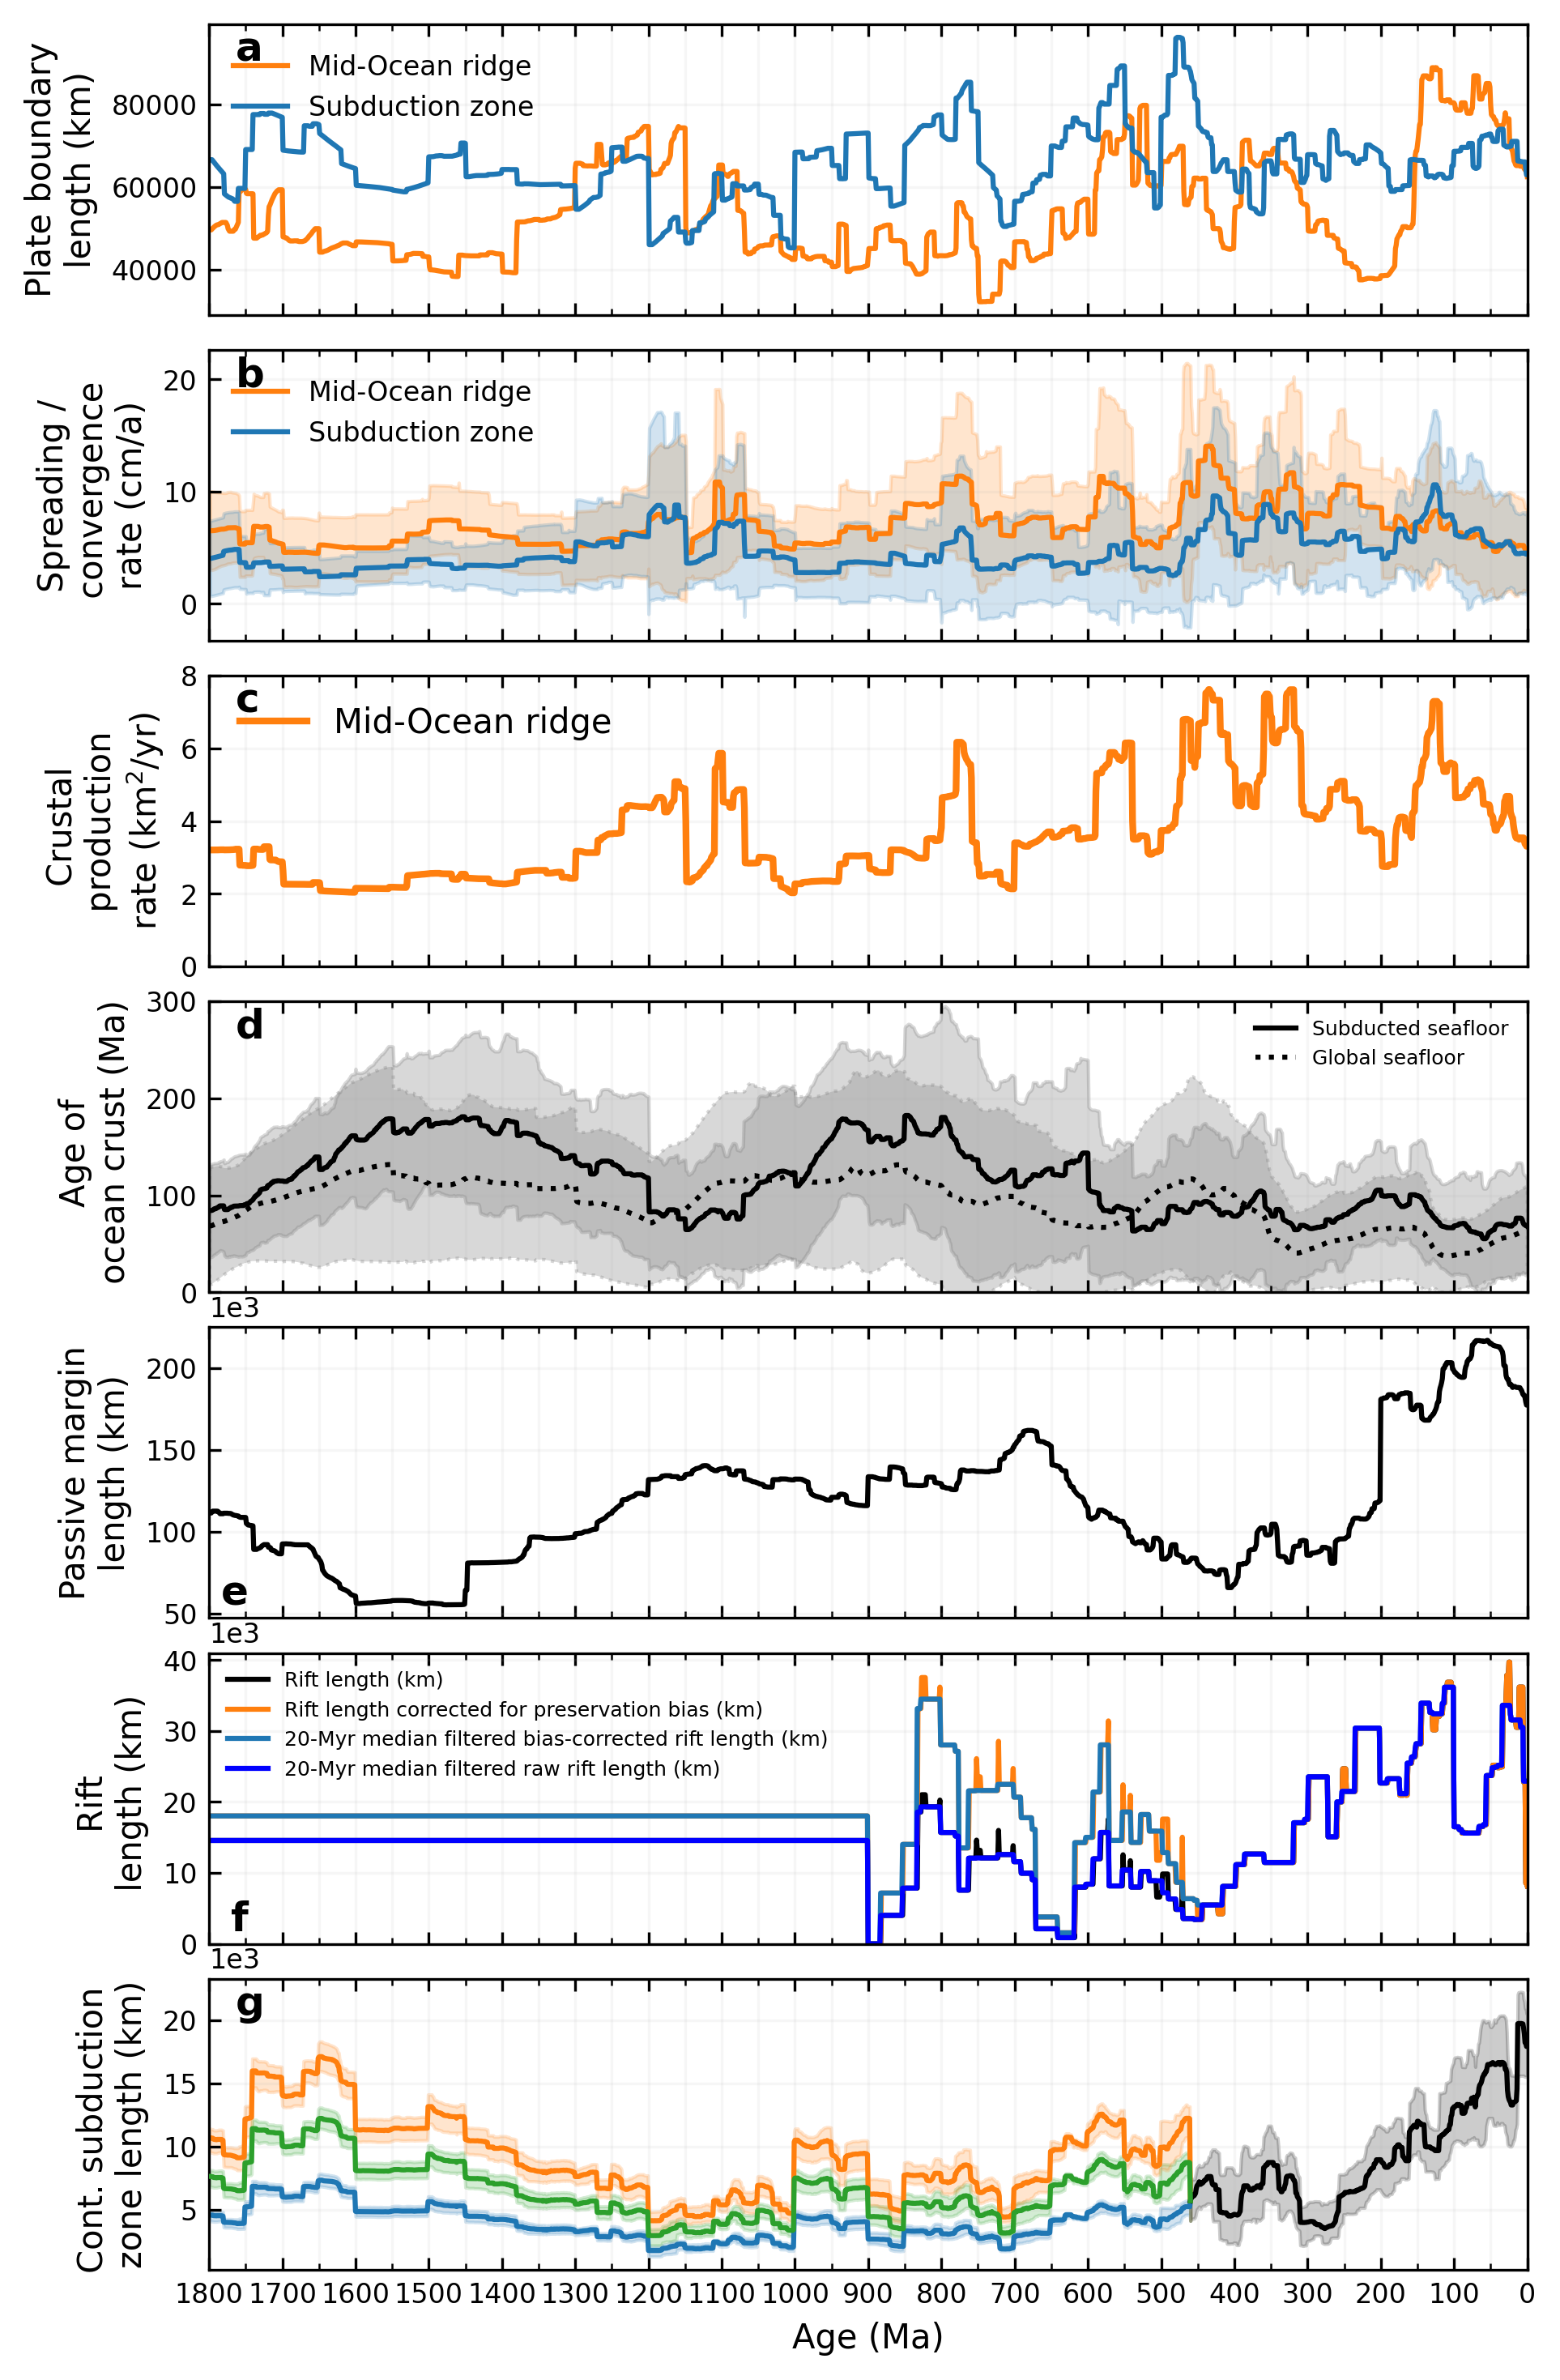

In [43]:
fig, axes = plt.subplots(7, 1, figsize=(7,12), dpi=300)
fig.subplots_adjust(hspace=0.05)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
n_axes = len(axes)

for n, ax in enumerate(axes):
    axes[n].tick_params(axis='both', labelsize=8)
    if n>3:
        axes[n].ticklabel_format(style='sci', axis='y', scilimits=(3,3))
        axes[n].yaxis.get_offset_text().set_fontsize(8)

axes[0].set_ylabel('Plate boundary\nlength (km)')
ln1, = axes[0].plot(reconstruction_times, ridge_len_sum, c='C1',  label="Mid-Ocean ridge")
ln2, = axes[0].plot(reconstruction_times, subd_len_sum, c='C0', label='Subduction zone')
axes[0].legend(loc='upper left', frameon=False, prop={'size': 8}, bbox_to_anchor=(0.00, 0.98),)

axes[1].set_ylabel('Spreading /\n convergence\nrate (cm/a)')
axes[1].fill_between(reconstruction_times, ridge_vel_mean-ridge_vel_std, ridge_vel_mean+ridge_vel_std,
                     edgecolor='k', color='C1', alpha=0.2)
axes[1].fill_between(reconstruction_times, subd_vel_mean-subd_vel_std, subd_vel_mean+subd_vel_std,
                     edgecolor='k', color='C0', alpha=0.2)
axes[1].plot(reconstruction_times, ridge_vel_mean, c='C1', label="Mid-Ocean ridge")
axes[1].plot(reconstruction_times, subd_vel_mean, c='C0', label="Subduction zone")
axes[1].legend(loc='upper left', frameon=False, prop={'size': 8}, bbox_to_anchor=(0.00, 0.98))

axes[2].set_ylabel('Crustal \n production \nrate (km$^2$/yr)')
axes[2].plot(reconstruction_times, ridge_surface_area, linewidth=2, c='C1', label="Mid-Ocean ridge")
axes[2].legend(loc='upper left', frameon=False)
axes[2].set_ylim([0,8])

axes[3].set_ylabel('Age of \n ocean crust (Ma)')
axes[3].fill_between(reconstruction_times, age_mean-age_std, age_mean+age_std, color='0.5', alpha=0.3)
axes[3].plot(reconstruction_times, age_mean, c='k', label="Subducted seafloor")
axes[3].fill_between(reconstruction_times, age_global_mean-age_global_std, age_global_mean+age_global_std, color='0.5', alpha=0.3, linestyle=":")
axes[3].plot(reconstruction_times, age_global_mean, c='k', label="Global seafloor", linestyle=":")
axes[3].legend(loc='upper right', frameon=False, prop={'size': 6})
axes[3].set_ylim([0,300])

axes[4].set_ylabel('Passive margin\nlength (km)')
axes[4].plot(reconstruction_times, passive_margin_lengths_global, c='k')
axes[4].set_xticks(np.arange(1800,-1,-100),  )
axes[4].set_yticks(np.arange(50000,210001,50000))
#axes[4].set_xticklabels(axes[1].get_xticks(), rotation = 45)
axes[4].ticklabel_format(useOffset=True)

axes[5].set_ylabel('Rift \n length (km)')
ln3 = axes[5].plot(reconstruction_times[::-1], 
                   extended_raw_rift_length, c='k', label="Rift length (km)"
)
ln3 = axes[5].plot(reconstruction_times[::-1], 
                   extended_multiplier_rift_length, c='C1', label="Rift length corrected for preservation bias (km)"
)
ln3 = axes[5].plot(reconstruction_times[::-1], 
                   filtered_multiplier_rift_lengths, c='C0', label="20-Myr median filtered bias-corrected rift length (km)"
)
ln3 = axes[5].plot(reconstruction_times[::-1], 
                   filtered_raw_rift_lengths, c='b', label="20-Myr median filtered raw rift length (km)")

axes[5].set_xticks(np.arange(1800,-1,-100),  )
axes[5].set_ylim([0,41000])
axes[5].set_yticks(np.arange(0,41001,10000))
axes[5].legend(loc='upper left', frameon=False, prop={'size': 6})


# Continental arcs with carb. platforms (km) - from 1800-460, 

colors = ['C0', 'C2', 'C1']
# This is plotted directly from the csv saved above. We use the arc_times array which is set from 0,1000. 
arc_times = reconstruction_times[::-1]
for c in range(0,3):
    
    percentage = percentages[c]
    
    len_pd = pd.read_csv(
        output_directory+"/csv/combined_carbonate_platform_len_{}percent.csv".format(percentage*100),
        index_col=0
    )
    
    headers = ['min_combined_continent_carbonate_platform_length', 
               'mean_combined_continent_carbonate_platform_length',
               'max_combined_continent_carbonate_platform_length' ]

    # Flip the arrays to match easy slicing of the array
    min_scaled_len = np.ravel(len_pd[headers[0]].to_numpy())[::-1]
    mean_scaled_len = np.ravel(len_pd[headers[1]].to_numpy())[::-1]
    max_scaled_len = np.ravel(len_pd[headers[2]].to_numpy())[::-1]

    # If plotting the 35% reduction, we want it to be the topmost layer - hence give it zorder 4. 
    if c == 1:
        axes[6].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100),
            zorder=4
        )
    else:

        axes[6].plot(
            arc_times[460:], 
            mean_scaled_len[460:],
            color=colors[c], 
            label='Carbonate platform length, percentage {}'.format(percentage*100)
        )
    axes[6].fill_between(
        arc_times[460:], 
        min_scaled_len[460:], 
        max_scaled_len[460:], 
        color=colors[c], alpha=0.2, 
        #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
    )

# From 460-0: carbonate platform lengths - trench lengths masked by a double k-d tree: proximity to both continents
# and carbonate platforms. 
axes[6].plot(
    arc_times[:461], 
    mean_scaled_len[:461],
    c='k', 
    label='Carbonate platform length post-460Ma')
axes[6].fill_between(
    arc_times[:461], 
    min_scaled_len[:461], 
    max_scaled_len[:461], 
    color='k', alpha=0.2, 
    #label='Uncertainty from 450km and 250km, \n percentage {}km'.format(d_tols[c])
)
axes[6].set_ylabel('Cont. subduction \nzone length (km)')
axes[6].set_xticks(np.arange(1800,-1,-100),  )

"""
# From 1800-460: continental arc lengths - trench lengths masked by a single k-d tree: proximity to only continents
# as we don't have carbonate platform polygons yet. 
axes[5].set_ylabel('Continental arc \n length (km)')
ln3 = axes[5].plot(reconstruction_times[0:1338], 
                   mean_cont_arc_length[0:1338], c='k', label="Mean dist. tolerance {} km".format(350)
)
axes[5].fill_between(reconstruction_times[0:1338], min_cont_arc_length[0:1338], max_cont_arc_length[0:1338], 
                 color='k', alpha=0.2, label="Uncertainty from min and max dist. tolerances")
axes[5].set_xticks(np.arange(1800,-1,-100),  )
axes[5].set_ylim([0,55000])
axes[5].set_yticks(np.arange(0,55001,10000))
"""


plt.grid(which='both', alpha=0.1)
for i, ax in enumerate(axes):
    ax.set_xlim(max_time, 0)
    ax.set_xticks(np.arange(1800,-1,-100))
    plt.xticks(fontsize=8)
    if i < n_axes-1:
        ax.grid(alpha=0.1, which='both')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.set_xticklabels([])
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
    else:
        #ax.set_xticklabels(axes[6].get_xticks()[::2], rotation = 45)
        ax.tick_params(axis="both", direction="in", which="both", right=False, top=True)
        ax.xaxis.set_minor_locator(MultipleLocator(50))
        ax.set_xticklabels(axes[n_axes-1].get_xticks())
        ax.set_xlabel("Age (Ma)")
        
img_id = ["a","b","c","d","e","f","g"]
for i, ax in enumerate(axes):

    if i == 4 or i == 5:
        ax.annotate('{}'.format(img_id[i]), xy=(0.03, 0.15), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='right', verticalalignment='top')
    else:
        ax.annotate('{}'.format(img_id[i]), xy=(0.02, 0.98), xycoords='axes fraction', fontsize=12, fontweight="bold",
                horizontalalignment='left', verticalalignment='top')

plt.subplots_adjust(hspace=0.12)
plt.show()
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt3.pdf", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt3.svg", dpi=300, bbox_inches='tight')
fig.savefig(output_directory+"/figures/plate_tectonic_stats_pt3.png", dpi=300, bbox_inches='tight')
